In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

np.random.seed(42)

df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[columns]

# Разделение
data_train, data_temp = train_test_split(df, test_size=0.4, random_state=1)
data_val, data_test = train_test_split(data_temp, test_size=0.5, random_state=1)

print(f"обучающая выборка: {data_train.shape}")
print(f"валидационная выборка: {data_val.shape}")
print(f"тестовая выборка: {data_test.shape}")

обучающая выборка: (27126, 15)
валидационная выборка: (9042, 15)
тестовая выборка: (9043, 15)


In [6]:
num_columns = ['balance', 'day', 'duration', 'previous']
auc_scores = {}

# Вычисление AUC 
for col in num_columns:
    auc = roc_auc_score(data_train['y'], data_train[col])
    if auc < 0.5:
        auc = roc_auc_score(data_train['y'], -data_train[col])
    auc_scores[col] = auc

print("AUC:", auc_scores)

AUC: {'balance': 0.5916931412945473, 'day': 0.5291275984648961, 'duration': 0.8128648066681694, 'previous': 0.5986704105715122}


In [7]:
# one-hot-encoding
train_dict = data_train.to_dict(orient='records')
val_dict = data_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

y_train = data_train['y'].values
y_val = data_val['y'].values

# Обучение логистической регрессии
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# AUC на валидационной выборке
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC на валидационной выборке: {auc:.3f}")

AUC на валидационной выборке: 1.000


In [8]:
# Преобразуем 'yes' и 'no' в 1 и 0
data_train['y'] = data_train['y'].apply(lambda x: 1 if x == 'yes' else 0)
data_val['y'] = data_val['y'].apply(lambda x: 1 if x == 'yes' else 0)
y_train = data_train['y'].values
y_val = data_val['y'].values

D:\anastasia\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


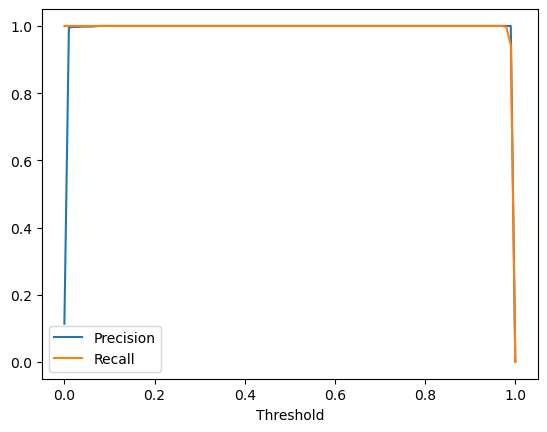

порог, на котором пересекаются Precision и Recall: 0.08


In [9]:
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred >= threshold).astype(int)
    precision_scores.append(precision_score(y_val, y_pred_threshold))
    recall_scores.append(recall_score(y_val, y_pred_threshold))

plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

# Найдем порог пересечения
crossing_threshold = thresholds[np.argmin(np.abs(np.array(precision_scores) - np.array(recall_scores)))]
print(f"порог пересечения Precision и Recall: {crossing_threshold}")

In [10]:
f1_scores = [f1_score(y_val, (y_pred >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"максимум F1 score достигается при пороге: {best_threshold}")

максимум F1 score достигается при пороге: 0.08


In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
C_values = [0.000001, 0.001, 1]
best_C = None
best_mean_auc = 0

for C in C_values:
    aucs = []
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    for train_idx, val_idx in kf.split(data_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_fold_train, y_fold_train)
        y_pred_fold = model.predict_proba(X_fold_val)[:, 1]
        aucs.append(roc_auc_score(y_fold_val, y_pred_fold))
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    print(f"C={C} - средний AUC: {mean_auc:.3f}, стандартное отклонение: {std_auc:.3f}")
    
    if mean_auc > best_mean_auc:
        best_C = C
        best_mean_auc = mean_auc

print(f"лучшее значение C: {best_C}")

C=1e-06 - средний AUC: 0.698, стандартное отклонение: 0.008
C=0.001 - средний AUC: 0.996, стандартное отклонение: 0.001
C=1 - средний AUC: 1.000, стандартное отклонение: 0.000
лучшее значение C: 1
